In [1]:
#Importing relevant packages 
import numpy as np
import pandas as pd

import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To save and open previously saved machine learning models 
from datetime import datetime

#Importing NLTK and NLP packages for (voluntary) preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict
from tqdm import tqdm

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary  # You might need to install gensim first 
from gensim.models.ldamulticore import LdaMulticore

# Topic Models

In this lab, we will apply a 50-topic LDA model to tweets from US Members of Congress to examine discussions about COVID-19 by Democrats and Republicans over time. Who was quicker to set the agenda around COVID-19, Democrats or Republicans? Make a guess if you know something about US politics.

The dataset is the same as for the word discovery lab and has been preprocessed similarly. The tweets have been subsetted from 2019 and later, because we are mainly interested in tweets that (may) capture the COVID-19 crisis. The preprocessed dataset is called 'MOCTweets_preprocessed.csv.bz2'. 

#### If you wish to replicate the preprocessing based on the full dataset from the exercise on word discovery, these are the steps that have been taken:

1. Changing 'date' from str type object to datetime type 
2. Subsetting to 2019 and later 
3. Removing unneeded columns (all except 'date', 'text', 'affiliation', and 'nominate_name')
2. Removing duplicated tweets 
7. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
7. Removing instances of "&amp"
8. Replacing all remaining "&" with "and"
8. Removing odd special characters that show up in topic model ("┻","┃","━","┳","┓","┏","┛")
9. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Replacing "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
6. Removing "RT" and "via"
11. Removing mentions (@someone)
10. Removing numbers, removing punctuation (except hyphens and #), removing separators, removing urls, lowercasing, removing stopwords, lemmatizing, and stemming.


In [3]:
#### Replicating preprocessing the data from earlier  

# Importing data
tweets = pd.read_csv("MOC_Tweets.csv")

# Changing data to datetime type
tweets['date']=pd.to_datetime(tweets['date'], format = '%Y%m%d')

#Subsetting the data to span 2019 and later 
tweets = tweets.loc[tweets.date > datetime(2018,12,31)]

#Removing duplicated tweets 
tweets = tweets.drop_duplicates(subset = 'tweet_id')

#Redefining dataset to only include useful columns 
tweets = tweets[['date','text','affiliation','nominate_name']]

In [4]:
#Locating politicians marked as 'Independent' affiliation and turning these into Democrats
print(tweets.loc[tweets.affiliation == 'Independent']['nominate_name'].value_counts()) # Making value_counts of Independent as affliation

tweets['affiliation'] = tweets['affiliation'].apply(lambda x: 'Democrat' if x == 'Independent' else x)

nominate_name
SANDERS, Bernard            1512
KING, Angus Stanley, Jr.     557
Name: count, dtype: int64


In [5]:
#Reusing and tweaking preprocessing steps from last week to fit specifics of this dataset.
def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    #Using the module string to define what punctuation we want removed
    my_punctuation = string.punctuation.replace('#','') # We don't want "#" or "-" removed  
    my_punctuation = my_punctuation.replace('-','')
    my_punctuation = my_punctuation+'’“”—'  # Adding additional punctuation that is not captured by string.punctuation 
    
    text = text.translate(str.maketrans('', '', my_punctuation)) # Text is "translated" to not include the punctuation we defined

    #Removing odd special characters 
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Tokenizing (separators and superfluous whitespace are also removed during tokenization)
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens

# Preprocessing text: You can get a progress bar by importing tqdm and using progress_apply instead of apply. 
tqdm.pandas()
tweets['tokenized']=tweets['text'].progress_apply(lambda x:preprocess(x)) # # This can take some time 

100%|████████████████████████████████████████████████████████████████████████| 579820/579820 [04:42<00:00, 2053.79it/s]


In [6]:
#Lemmatization and removing stopwords
def lemmatize(tokens):
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

tweets['text_lemma']=tweets['tokenized'].progress_apply(lambda x:lemmatize(x)) # # This can take some time 

100%|████████████████████████████████████████████████████████████████████████| 579820/579820 [2:52:10<00:00, 56.13it/s]


In [7]:
# Stemming and and removing stopwords

def stem(tokens):
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)

tweets['text_stemmed']=tweets['tokenized'].progress_apply(lambda x:lemmatize(x)) # # This can take some time 

100%|█████████████████████████████████████████████████████████████████████████| 579820/579820 [27:05<00:00, 356.80it/s]


In [11]:
#Saving the preprocessed dataset
tweets.to_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

### 1: Preparing the data for topic modelling

The preprocessed data includes columns for date, affiliation, nominate name, tweet text, and two columns of preprocessed tweet text: one stemmed and one lemmatized. We will be using the stemmed text today. 

1. Import the dataframe
2. Convert 'date' from str type object to datetime type 
3. Some tweets have been fully removed - e.g., if they contained only links. Replace NaN values with an empty string in the stemmed text (NaN --> ""). Then use `groupby` and `agg` to group the data by *date* and *affiliation*, and aggregate the stemmed tweet text within each of these categories into one long string. The result should be one string of combined democrat tweets and one string of combined republican tweets for each date in the corpus. You do not need to save the nominate names. 
4. For each row, tokenize the stemmed text data into unigrams. Consider using NLTK's `TweetTokenizer`, which is made to handle e.g. hashtags and emojis.
5. For each row, define a function using `nltk.bigrams` to create bigrams from the unigrams. This function will return a list of tuples. Connect the two words in each bigram tuple with an underscore to get a list of bigram tokens. E.g.: [(great, news), (news, presid), (presid, signatur)] --> ['great_news', 'news_presid', 'presid_signatur']
6. For each row, combine the unigrams and bigrams in one cell to create a list of all unigram and bigram tokens in that row.


In [12]:
# 1. Importing the processed data
tweets = pd.read_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

In [13]:
# 2. Converting date from string to datetime object
tweets['date']=pd.to_datetime(tweets['date'], format = '%Y-%m-%d')

In [14]:
# 3. Replacing NaN-values and aggregating data by date
tweets.text_lemma = tweets.text_lemma.apply(lambda x: '' if str(x) == 'nan' else x) #replacing "nan" with nothing
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)


#Aggregating tweet data by dates and affiliation 
# agg() is an aggregation function in shape of a dictionary in which we specify which variables (documents here) we want aggregated (joined)
tweets_agg = tweets.groupby(['date', 'affiliation'], as_index = False).agg({'text': ' '.join, #as_index= False, so these variables are not the index
                                                                            'text_lemma': ' '.join, # documents are joined with a spacce
                                                                            'text_stemmed': ' '.join})
#Checking dimensions of new dataset and viewing the dataset
print(tweets_agg.shape)
tweets_agg.head()

(864, 5)


,date,affiliation,text,text_lemma,text_stemmed
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedy great news president signature tonight...
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happy healthy prosperous #happynewyear # k #ne...
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor tell wont get pay bill wont ge...
3,2019-01-02,Republican,RT @cdw: I see that Mr. Alright Alright Alrigh...,see mr alright alright alright sideline #hooke...,see mr alright alright alright sideline #hooke...
4,2019-01-03,Democrat,"Before the shutdown, before the pay freeze, th...",shutdown pay freeze federal government suffer ...,shutdown pay freeze federal government suffer ...


In [15]:
# 4. Tokenizing stemmed text

#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas() #Creates a progress bar and below use "progress_apply" instead of "apply" to create a progress bar (This is more of a "nice to have" than a "need to have")

#Tokenizing and creating a column of unigrams from the stemmed tweet text. 
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

100%|████████████████████████████████████████████████████████████████████████████████| 864/864 [01:33<00:00,  9.22it/s]


In [16]:
# 5. Creating bigrams

#Defining a function that will create bigrams 
def bigrams(doc): # a doc is a list of unigrams in same order as in tweets 
    
    bigrams = [] #Empty list to save the bigrams
    
    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams as tuples with nltk.bigrams and iterating over these them
        bigrams.append("_".join(bigram))    #Joining each bigram-tuple pair with an underscore and saving to list
    
    return bigrams

#Creating a column with bigrams by applying function to column of unigrams
tweets_agg['bigrams'] = tweets_agg.unigrams.progress_apply(lambda x: bigrams(x))


100%|████████████████████████████████████████████████████████████████████████████████| 864/864 [00:11<00:00, 76.36it/s]


In [17]:
# 6. Combining unigrams and bigrams to a column of tokens
tweets_agg['tokens'] = tweets_agg.unigrams+tweets_agg.bigrams # adding the two lists of respectively unigrams and bigrams

In [48]:
tweets_agg['tokens'][0]

['tragedy',
 'great',
 'news',
 'president',
 'signature',
 'tonight',
 '#ashantialert',
 'act',
 'law',
 'land',
 'honor',
 'work',
 'ashanti',
 'billy',
 'parent',
 'hampton',
 'roads',
 'community',
 'pass',
 'life-saving',
 'legislation',
 'wish',
 'everyone',
 'around',
 'commonwealth',
 'happy',
 'healthy',
 'new',
 'year',
 'wish',
 'family',
 'happy',
 'healthy',
 'new',
 'year',
 '🎉',
 'wish',
 'everyone',
 'happy',
 'healthy',
 'new',
 'year',
 'give',
 'democrats',
 'great',
 'opportunity',
 'show',
 'govern',
 'responsibly',
 'quickly',
 'pass',
 'plan',
 'end',
 'irresponsible',
 '#trumpshutdown',
 '–',
 'first',
 'sign',
 'thing',
 'come',
 'new',
 'democratic',
 'majority',
 'commit',
 'work',
 '#forthepeople',
 'republican',
 'celebrate',
 'one-year',
 'anniversary',
 'trump',
 'tax',
 'cut',
 'shouldnt',
 'exactly',
 'say',
 'gop',
 'jam',
 'ill',
 'advise',
 'expensive',
 'unfair',
 'tax',
 'scam',
 'way',
 'mean',
 'committee',
 'family',
 'happy',
 'new',
 'year',
 

### 2: Creating a corpus object

We will be using the `gensim` module to create a corpus object and filter very frequent and in-frequent words. Read the documentation here: https://radimrehurek.com/gensim/corpora/dictionary.html 

1. Create a dictionary mapping between words and their ids. This code is provided for you. This can take a couple of seconds.  
2. Use `filter_extremes` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10 documents).
3. You can inspect the vocabulary using either `id2token` or `token2id`. 
4. Create a corpus object. Essentially, use `doc2bow` in a list comprehension to create a list containing a bag of words for each document (aka for each row in the dataframe). Each bag of words should be a list containing tuples with 1) an index indicating the word and 2) the frequency of that word. The code could look like: `corpus = [id2word.doc2bow(doc) for doc in df['tokens']]`.


In [18]:
# 1. Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) # A dictionary is created through which each token gets a unique id 

#Viewing how many words are in our vocabulary
print(len(id2word))

3148774


In [19]:
# 2. Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, #filtering out words appearing in less than 10 documents
                        no_above=.999, #filtering out words appearing in more than 99,9% of all documents
                        keep_n=None) # If we don't set keep_n=None, then the vocabulary "only" contains the 10000 most frequent words 

#Viewing how many words are now in our vocabulary after filtering
print(len(id2word))

125163


In [20]:
# 3. Inspecting vocabulary

# #Uncomment to print the full vocabulary
# for i, token in enumerate(id2word.token2id.keys()):#token2id creates a dict with tokens as keys
#     print (i,token)

# Or check the id of specific interesting words
print('The ID for "congress" is '+str(id2word.token2id['congress'])+'\nThe ID for "dog" is '+str(id2word.token2id['dog'])) 


The ID for "congress" is 438
The ID for "dog" is 19973


In [21]:
# 4. Creating corpus

# Convert documents into the bag-of-words (BoW) format. 
# We get a list of tuples with (token_id, token_count) for each document.
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']] 

### 3: Topic modelling

We will run topic modelling using an LDA implementation from the `gensim` module. You can find the documentation here: https://radimrehurek.com/gensim/models/ldamulticore.html 

We will investigate the results of a model with 50 topics. However, this takes several hours to run. Therefore, first try the LDA algorithm with approx. 10 topics and then download the pre-trained model to investigate the 50-topic results.

1. Run the LDA algorithm with the provided code
2. The typical way to get a sense of what each topic actually is is by looking at the tokens that are most predictive for each topic. Use `print_topics` to see the 10 (or more) most predictive tokens for each topic. Optional: When using `print_topics`, the model weights are included. If you want to clean this, you can use regex to filter out everything but the words.


**A note on setting parameters:**

- Passes and iterations: As this is just a test run, passes and iterations are set quite low. If you want to use topic modelling in your project, you should make sure to set passes and iterations high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000. 
- Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001


**A note on choosing the number of topics:**
Choosing the number of topics is not straightforward. Both Barberá (2019) and Munger (2019) use 10-fold cross-validation for the log-likelihood and perplexity. If you want to implement these models in your own work and want to learn how to do this, read about hyperparameter tuning [here](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2). 

At the same time, there is no statistic that can tell you how many topics you want: "There is often a negative relationship between the best-fitting model and the substantive information provided" (Grimmer and Stewart 2013). So in the end it is a judgment call on the side of the researcher, which can be guided by statistics.

If topics repeat themselves, this may suggest that we chose too many topics for the dataset. 


In [22]:
# 1. Running the LDA

#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes = 1, iterations = 50)


2025-04-28 20:54:29,707 : INFO : using symmetric alpha at 0.1
2025-04-28 20:54:29,720 : INFO : using symmetric eta at 0.1
2025-04-28 20:54:29,751 : INFO : using serial LDA version on this node
2025-04-28 20:54:29,928 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 864 documents, updating every 6000 documents, evaluating every ~864 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-28 20:54:29,929 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-28 20:54:29,941 : INFO : training LDA model using 3 processes
2025-04-28 20:54:41,795 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #864/864, outstanding queue size 1
2025-04-28 20:54:59,884 : INFO : topic #9 (0.100): 0.003*"community" + 0.003*"trump" + 0.003*"house" + 0.003*"im" + 0.003*"bill" + 0.003*"president" + 0.003*"people" + 0.003*"congress" + 0.003*"join" + 0.003*"day

In [23]:
#Disabling logging again
logging.disable(sys.maxsize)

In [24]:
# 2. Printing the 10 most preditive words/tokens of each topic

#Using regex to filter the words from the weights 
# In the regex below " is the opening and closing quotation mark of each word, [^"]* matches zero or more characters that are not a quotation mark
# Note that we could also have used the somewhat simpler r'"([#?\w]*)" but this would not include emojis. 
# re.findall to find all that matches our pattern

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(10,10)] # lda_model.print_topics gives a tuple of topic number and words with weighs 


# Printing the topics in a nice format
for id, tokens in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(tokens), end="\n\n")


------ Topic 0 ------
trump president need people support community im act house bill

------ Topic 1 ------
trump act president family need house day bill people support

------ Topic 2 ------
president trump house people need act community family im bill

------ Topic 3 ------
trump congress need support house president pass family community act

------ Topic 4 ------
trump people act bill president need house proud health family

------ Topic 5 ------
trump president community people need bill house act must im

------ Topic 6 ------
people need president family congress trump house im act support

------ Topic 7 ------
president people community act trump family house bill need support

------ Topic 8 ------
president - house act community family support people im country

------ Topic 9 ------
community trump house im bill president people congress join day



### 4.1: Investigating results: beta parameters

To investigate the results, load the pre-trained models with the provided code. 

1. Retrieve the estimated **beta parameters** from the model. There is a beta per token per topic. A beta indicates how predictive a token is of a document being assigned to a specific topic. Beta values can be accessed using either `get_topic_terms` (where you input the topic and number of most predictive tokens you want returned) or `get_topics` (which returns the full matrix of beta values).

**Hint**: Create a dataframe from the matrix generated by `get_topics` with token names as the column names. Tokens can be retrieved with the `id2word.token2id`.


2. Pick two or three topics (in the solution code the topics 1, 8, 16, 27, 28, 29, 31, 41, 47, 48 were chosen for visualization). Once you have the dataframe, `nlargest` can be used on a specific row to get the columns with the *n* largest values in that row. Get the 10 highest beta values and plot these in a horizontal barchart with `sns.barplot`, where x is the beta probability and y is the token. 

**Intended take-away**: The "top terms" for each topic are just the tokens that have the largest beta. 

**A note on the results**: You may notice that some topics have an even distributions of probabilities for all terms. This may be because the `minimum_probability` parameter is not low enough, because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, or because we have set the number of topics too high for the data. For your own projects, experiment with the parameters.

In [25]:
#Loading the pre-trained models
lda_model=pickle.load(open('LDA models/ldamodel_50t100p1000i000001minprob.sav', 'rb'))
corpus=pickle.load(open('LDA models/corpus_50t100p1000i000001minprob.sav', 'rb'))
id2word=pickle.load(open('LDA models/id2word_50t100p1000i000001minprob.sav', 'rb'))

In [26]:
# 1. Finding beta values for just one topic with get_topic_terms()
print('Token id and probability for topic 41: ')
lda_model.get_topic_terms(41,10) #Returns (Word ID, probability) pairs for the 10 most relevant words in topic 41

Token id and probability for topic 41: 


[(126204, 0.018707033),
 (126217, 0.012971616),
 (869, 0.008170186),
 (1017, 0.0070352694),
 (126279, 0.0060018497),
 (1563, 0.00573291),
 (3977, 0.005709222),
 (1807, 0.0053544473),
 (48, 0.0052366825),
 (1970, 0.0051983683)]

In [27]:
# 1. Creating a dataframe of beta values using get_topics()

# Printing shape of matrix using get_topics() 
print('The shape of matrix of topics and tokens is: ',lda_model.get_topics().shape)

# Creating a dataframe with tokens as columns and topics with beta values for each token as rows 
# token2id maps tokens to associated id. This is used to have words as column names instead of ids. 
beta_df = pd.DataFrame(lda_model.get_topics(),columns = list(id2word.token2id.keys()) )
beta_df

The shape of matrix of topics and tokens is:  (50, 126300)


,#,#_prioriti,#actonclim,#articlesofimpeach,#ashantialert,#az,#ca,#climatechang,#congress,#enoughisenough,...,#covidー,coronaviru_fund,spread_#covid,#coronaviru_fund,#covid_-,coronaviru_covid,emerg_#coronaviru,often_soap,#coronaviru_#covid,avoid_touch
0,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,...,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06
1,8.070066e-05,3.124541e-07,1.986390e-05,3.124541e-07,3.124541e-07,3.061454e-05,3.124551e-07,1.091940e-04,3.124541e-07,3.124545e-07,...,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07
2,7.917666e-06,7.917656e-06,7.917670e-06,7.917656e-06,7.917656e-06,7.917667e-06,7.917670e-06,7.917670e-06,7.917657e-06,7.917663e-06,...,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06
3,3.221107e-04,5.986412e-08,5.986441e-08,5.986413e-08,5.986412e-08,2.198963e-04,1.445711e-05,5.986446e-08,9.232468e-05,5.986414e-08,...,5.986412e-08,5.986411e-08,5.986412e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08
4,7.917663e-06,7.917657e-06,7.917664e-06,7.917657e-06,7.917657e-06,7.917659e-06,7.917659e-06,7.917662e-06,7.917658e-06,7.917659e-06,...,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06
5,4.846996e-04,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345118e-06,1.345117e-06,1.345117e-06,1.345117e-06,4.354685e-06,...,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06,1.345117e-06
6,9.113447e-04,2.471474e-07,2.471477e-07,2.471474e-07,2.471473e-07,3.418533e-04,2.463487e-05,1.513831e-05,2.472698e-07,2.471474e-07,...,2.471474e-07,2.471474e-07,2.471473e-07,2.471473e-07,2.471473e-07,2.471473e-07,2.471473e-07,2.471473e-07,2.471473e-07,2.471473e-07
7,1.237596e-04,1.641430e-07,1.781345e-04,1.641430e-07,1.641430e-07,4.801447e-05,2.864581e-05,8.766707e-05,1.641437e-07,1.132011e-04,...,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07,1.641430e-07
8,3.084828e-04,8.511633e-07,8.511634e-07,8.511633e-07,8.511633e-07,8.539769e-07,8.868747e-04,8.511634e-07,8.511634e-07,8.511633e-07,...,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07,8.511633e-07
9,1.870089e-06,1.837981e-06,1.837983e-06,1.837981e-06,1.837981e-06,1.838000e-06,1.837984e-06,1.074871e-04,1.837982e-06,1.837982e-06,...,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06,1.837981e-06


In [28]:
# Using dataframe to explore the 10 words with the highest beta values for a topic

for i in range(50): 
    print('Topic {}: Words with highest beta values\n\n'.format(i),
          beta_df.iloc[i].nlargest(10),"\n___\n") # Using iloc to search for the 10 largest values (.nlargest(10)) in neach row/topic

Topic 0: Words with highest beta values

 #                     0.000008
#_prioriti            0.000008
#actonclim            0.000008
#articlesofimpeach    0.000008
#ashantialert         0.000008
#az                   0.000008
#ca                   0.000008
#climatechang         0.000008
#congress             0.000008
#enoughisenough       0.000008
Name: 0, dtype: float32 
___

Topic 1: Words with highest beta values

 cut             0.017671
budget          0.016883
#trumpbudget    0.014111
trump           0.008760
presid          0.008279
medicar         0.006309
propos          0.005807
medicaid        0.005123
women           0.004771
program         0.004742
Name: 1, dtype: float32 
___

Topic 2: Words with highest beta values

 trump      0.000008
protect    0.000008
im         0.000008
need       0.000008
famili     0.000008
health     0.000008
commun     0.000008
vote       0.000008
act        0.000008
care       0.000008
Name: 2, dtype: float32 
___

Topic 3: Words with high

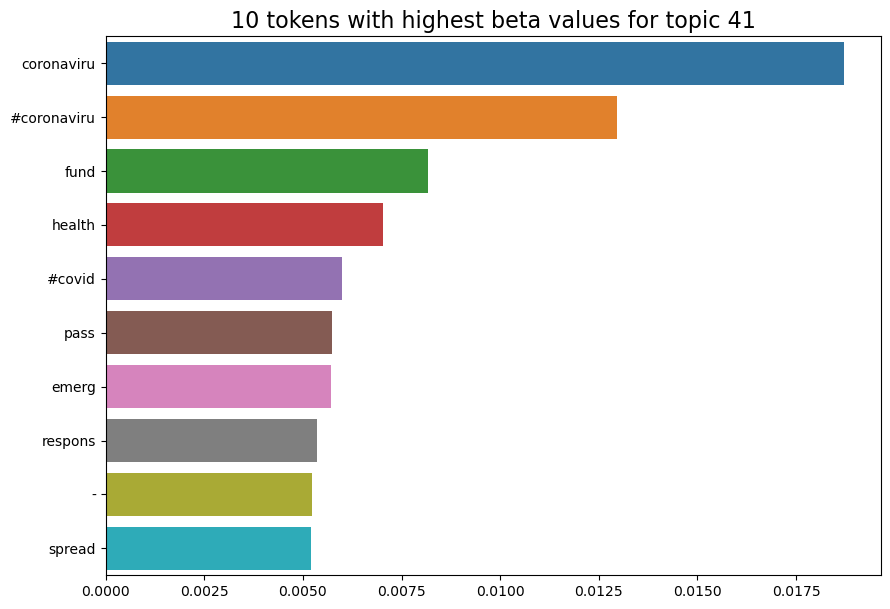

In [29]:
# 2. Picking topics to visualize 

#Visualizing the 10 tokens with highest beta values in topic 41
plt.figure(figsize = (10,7)) #behøver vi ikke 

ax = sns.barplot(x = beta_df.iloc[41].nlargest(10).values, # .values returns the beta values
                 y = beta_df.iloc[41].nlargest(10).index) # .index returns the words

plt.title('10 tokens with highest beta values for topic 41', fontsize = 16)
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


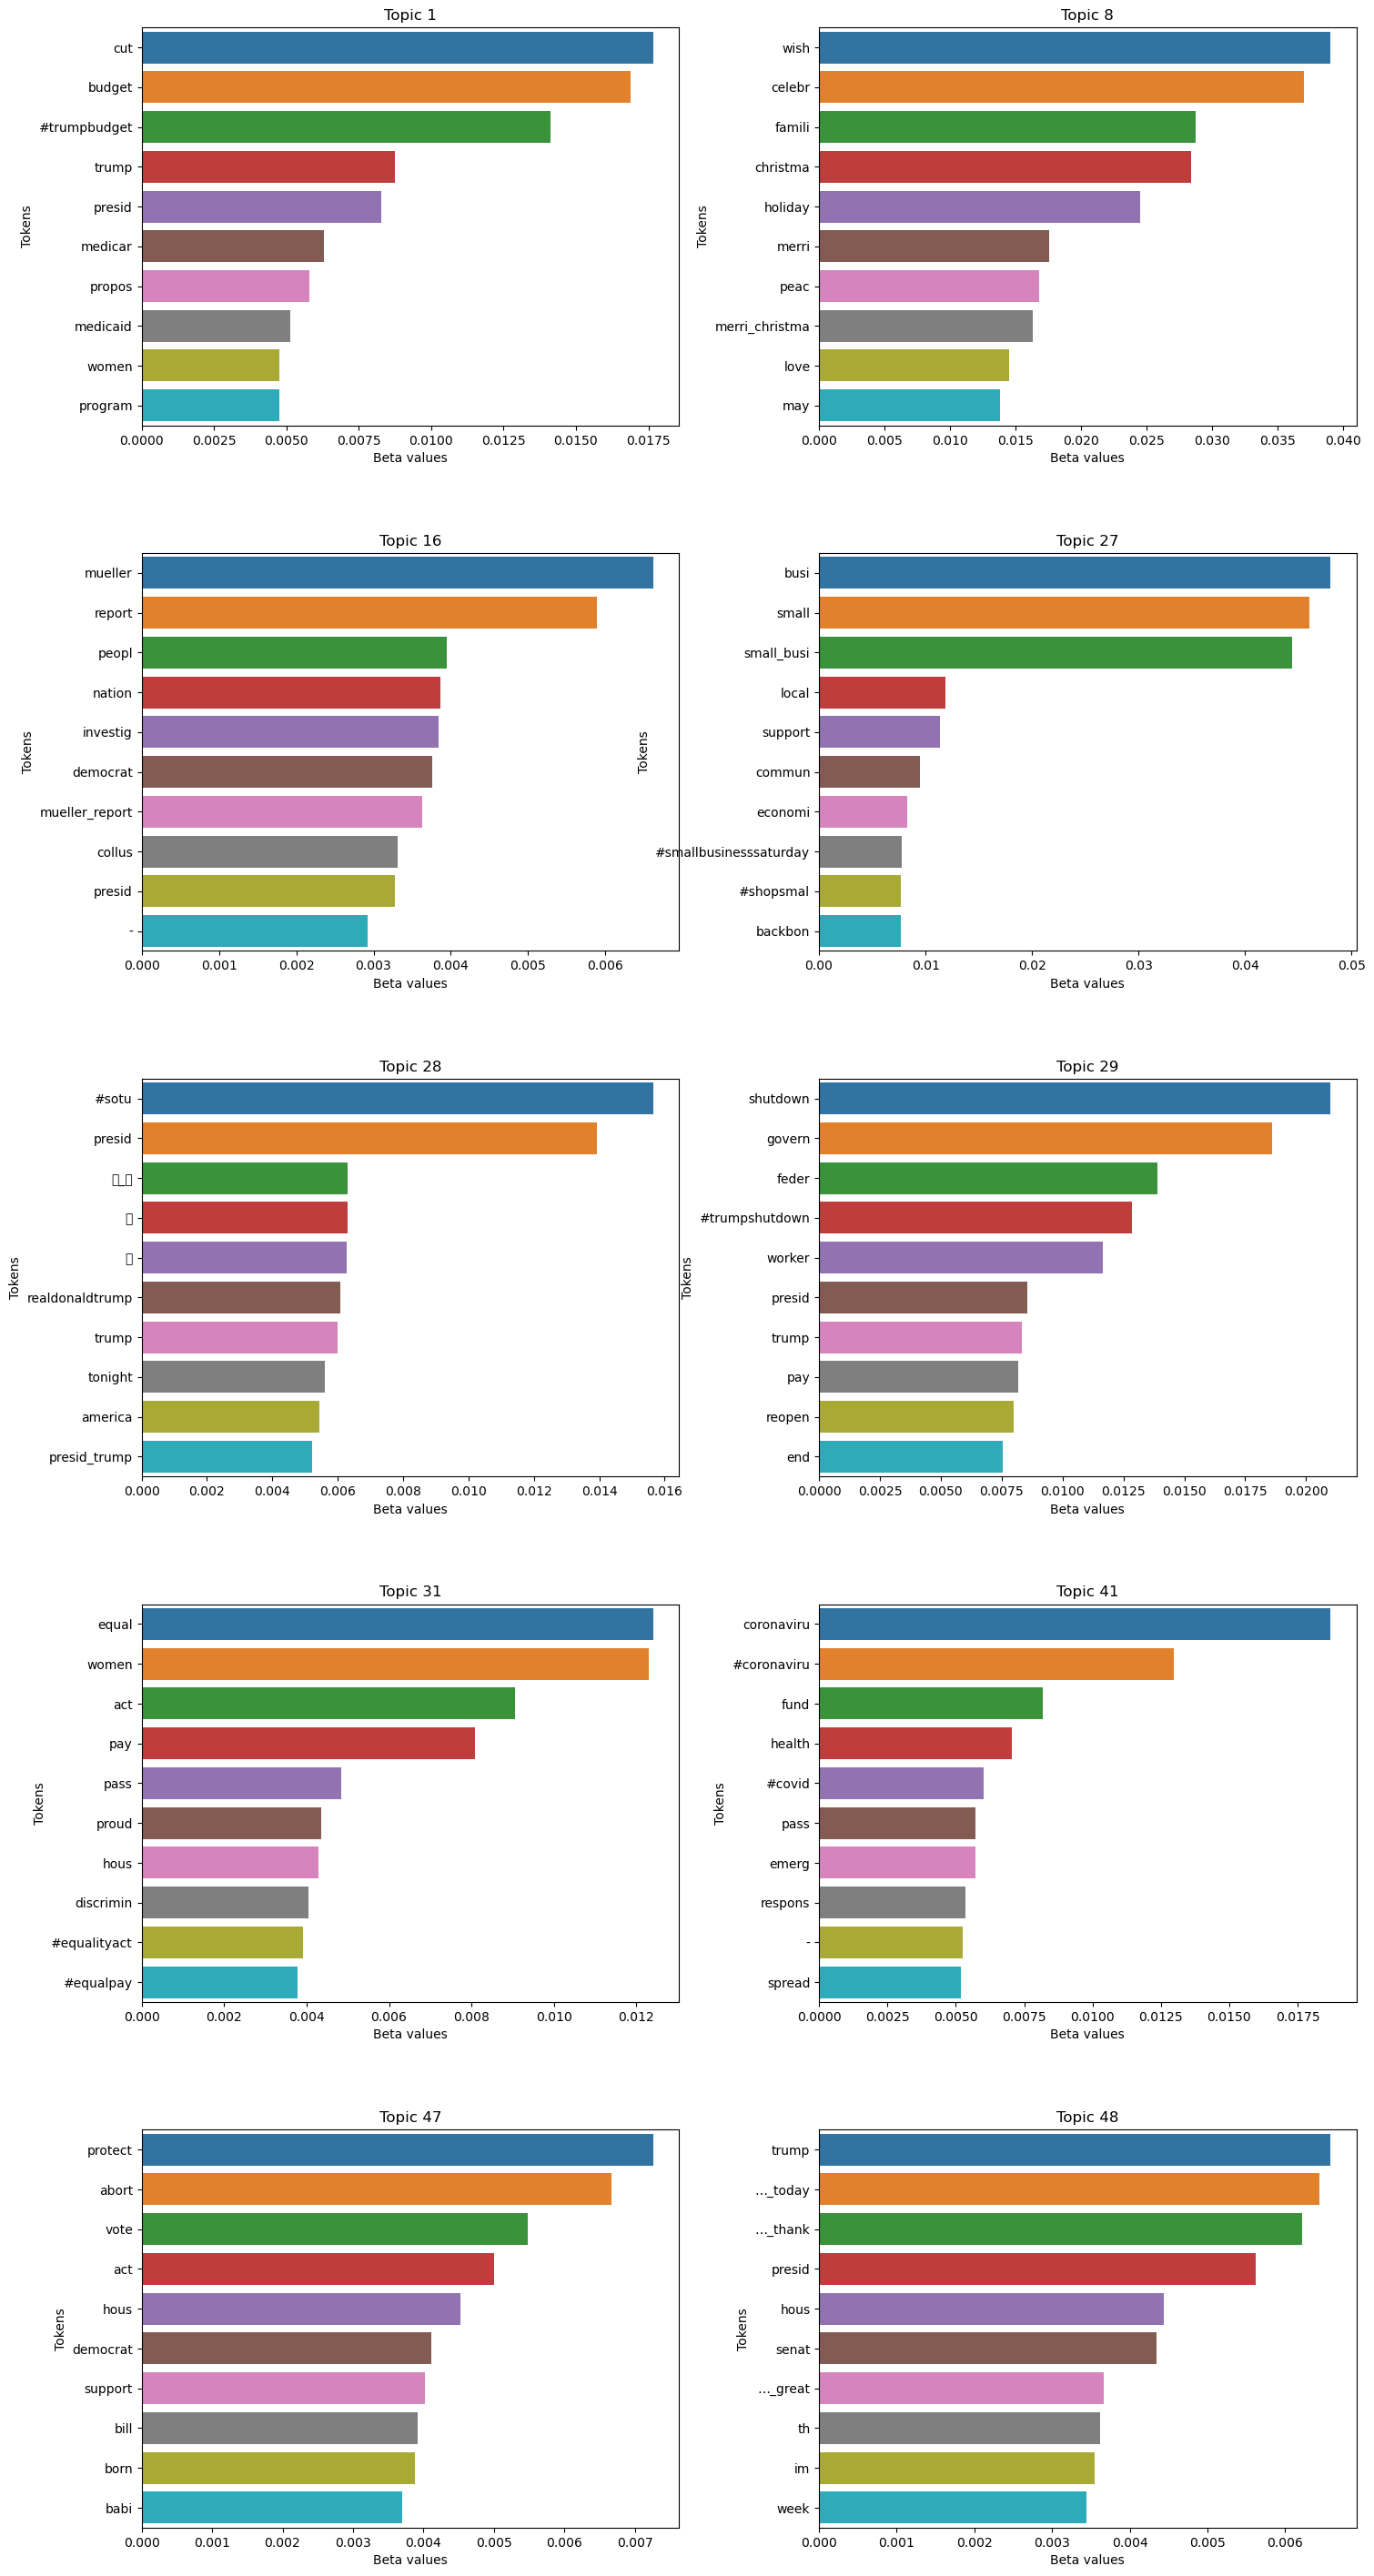

In [30]:
#Picking 10 topics to visualize
topics = [1, 8, 16, 27, 28, 29, 31, 41, 47, 48]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(10).values, 
                y = beta_df.iloc[topic].nlargest(10).index)
    
    ax.set(title='Topic {}'.format(topic), xlabel='Beta values',ylabel='Tokens') #Setting labels


plt.show()

### 4.2: Investigating results: gamma parameters

1. Retrieve the estimated **gamma parameters** from the model. For each document, you will get a list of topics with an associated gamma. The gammas indicate the probability (or amount) that a document is about a specific topic.Use `get_document_topics` with the full corpus to get lists of probabilities for each document. Set `minimum_probability = 0.0`. The code will be: `lda_model.get_document_topics(corpus, minimum_probability = 0.0)`. Make this a list. 
2. Save the probabilities in the original dataframe. You can find inspiration for how to do this in the pseudo-code:

**Pseudo-code to save the probabilities in the original dataframe:**

Use list comprehension to create a list of 50 topic names (e.g. topic_1, topic_2 etc.)

Create a dataframe filled with zeros of the shape (number of documents - 864, number of topics - 50) and with columns = the list of 50 topic names. 

For each index, document in the list of gamma probabilities: <br>
<font color=white>0000</font>for each topic-probability pair in the document: <br>
<font color=white>00000000</font>locate index and column with that topic name and save the probability

Concatenate this dataframe with the original dataframe over axis 1.


In [31]:
# 1.Getting lists of topic probabilities/gamma parameters for each document

document_probs=list(lda_model.get_document_topics(corpus, minimum_probability=0.0))

In [32]:
# 2. Saving gamma probabilties to dataframe  

# Creating a list of names for all 50 topics
topics = ['topic_{}'.format(t) for t in range(0,50)]

# Creating a dataframe of zeros that has shape: documents X topics. Columns are the list of names   
gamma_probs = pd.DataFrame(np.zeros((len(document_probs),50)), columns = topics)

for i, doc in enumerate(document_probs): #looping over document index and topic probabilities for each document 
    for pair in doc: # looping over all topic-probability-pairs in each document
        #locating correct document index and column name and saving each probability in the dataframe
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1] 

In [33]:
#Concatenating datarame of gamma probabilities with dataframe of aggragated tweets.  
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,date,affiliation,text,text_lemma,text_stemmed,unigrams,bigrams,tokens,topic_0,topic_1,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedy great news president signature tonight...,"[tragedy, great, news, president, signature, t...","[tragedy_great, great_news, news_president, pr...","[tragedy, great, news, president, signature, t...",4.003597e-06,4.003597e-06,...,0.000004,4.003597e-06,4.003597e-06,4.003597e-06,0.116614,4.003597e-06,4.003597e-06,4.003597e-06,4.003597e-06,4.003597e-06
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happy healthy prosperous #happynewyear # k #ne...,"[happy, healthy, prosperous, #happynewyear, #,...","[happy_healthy, healthy_prosperous, prosperous...","[happy, healthy, prosperous, #happynewyear, #,...",9.801448e-06,9.801448e-06,...,0.000010,9.801448e-06,9.801448e-06,9.801448e-06,0.207758,9.801448e-06,9.801448e-06,9.801448e-06,9.801448e-06,9.801448e-06
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor tell wont get pay bill wont ge...,"[amen, supervisor, tell, wont, get, pay, bill,...","[amen_supervisor, supervisor_tell, tell_wont, ...","[amen, supervisor, tell, wont, get, pay, bill,...",2.251315e-06,2.251315e-06,...,0.000002,2.251315e-06,2.251315e-06,2.251315e-06,0.001989,2.251315e-06,2.251315e-06,2.251315e-06,2.251315e-06,2.251315e-06
3,2019-01-02,Republican,RT @cdw: I see that Mr. Alright Alright Alrigh...,see mr alright alright alright sideline #hooke...,see mr alright alright alright sideline #hooke...,"[see, mr, alright, alright, alright, sideline,...","[see_mr, mr_alright, alright_alright, alright_...","[see, mr, alright, alright, alright, sideline,...",5.221434e-06,5.221434e-06,...,0.000005,5.221434e-06,5.221434e-06,5.221434e-06,0.003443,5.221434e-06,5.221434e-06,5.221434e-06,5.221434e-06,5.587973e-01
4,2019-01-03,Democrat,"Before the shutdown, before the pay freeze, th...",shutdown pay freeze federal government suffer ...,shutdown pay freeze federal government suffer ...,"[shutdown, pay, freeze, federal, government, s...","[shutdown_pay, pay_freeze, freeze_federal, fed...","[shutdown, pay, freeze, federal, government, s...",9.559949e-07,9.559949e-07,...,0.162080,9.559949e-07,9.559949e-07,9.559949e-07,0.000888,9.559949e-07,9.559949e-07,9.559949e-07,9.559949e-07,9.559949e-07


In [34]:
# Example to find 5 most prevalent topics for document 0
gamma_df[list(gamma_df.columns[8:])].iloc[0].nlargest(5)

topic_35    0.301299
topic_22    0.243662
topic_6     0.241687
topic_44    0.116614
topic_29    0.058502
Name: 0, dtype: float64

### 5: Visualizing the development of the coronavirus related topic 

Getting back to the original question: How has the topic of coronavirus progressed on Twitter among Members of Congress over time? 

1. Use `print_topics` to look through the 10 most relevant words of each topic and identify the topic related to coronavirus. 
2. If it is not already, convert the date column from string type to datetime type
3. Graph the development of the coronavirus topic over time. Create a plot where x = date, y = the covid topic, and hue = affiliation. 
4. Do the same with a subset of the dataset only including 2020. 

Can you see which party was quicker to set the agenda around COVID-19? 


In [35]:
# 1. look through 10 most relevant words to find corona topic

#Using regex from 3.3 to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(50,10)] #Making a list of lists of most relevant words for each topic

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    
#Topic 41 is coronavirus


------ Topic 0 ------
internet_open introduc_war intermediate-rang_nuclear intern_agreement internet_continu internet_free interest_attend intimid_us invit_help invest_act

------ Topic 1 ------
cut budget #trumpbudget trump presid medicar propos medicaid women program

------ Topic 2 ------
trump protect im need famili health commun vote act hous

------ Topic 3 ------
border secur democrat job nation govern - congress presid continu

------ Topic 4 ------
hous trump presid fight need women vote protect support act

------ Topic 5 ------
labor worker #laborday labor_day #dorian famili day union right wage

------ Topic 6 ------
new tax new_year job happi_new famili peopl wage first -

------ Topic 7 ------
vote war right act iran congress hous pass trump must

------ Topic 8 ------
wish celebr famili christma holiday merri peac merri_christma love may

------ Topic 9 ------
constitut happi lewandowski birthday nd usairforc nd_birthday happi_nd document air

------ Topic 10 ------
impe

In [36]:
# 2. Converting date from str type to datetime type
# This was done in exercise 1 - code to do it now is visible below 
# gamma_df['date'] = pd.to_datetime(gamma_df['date'])

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

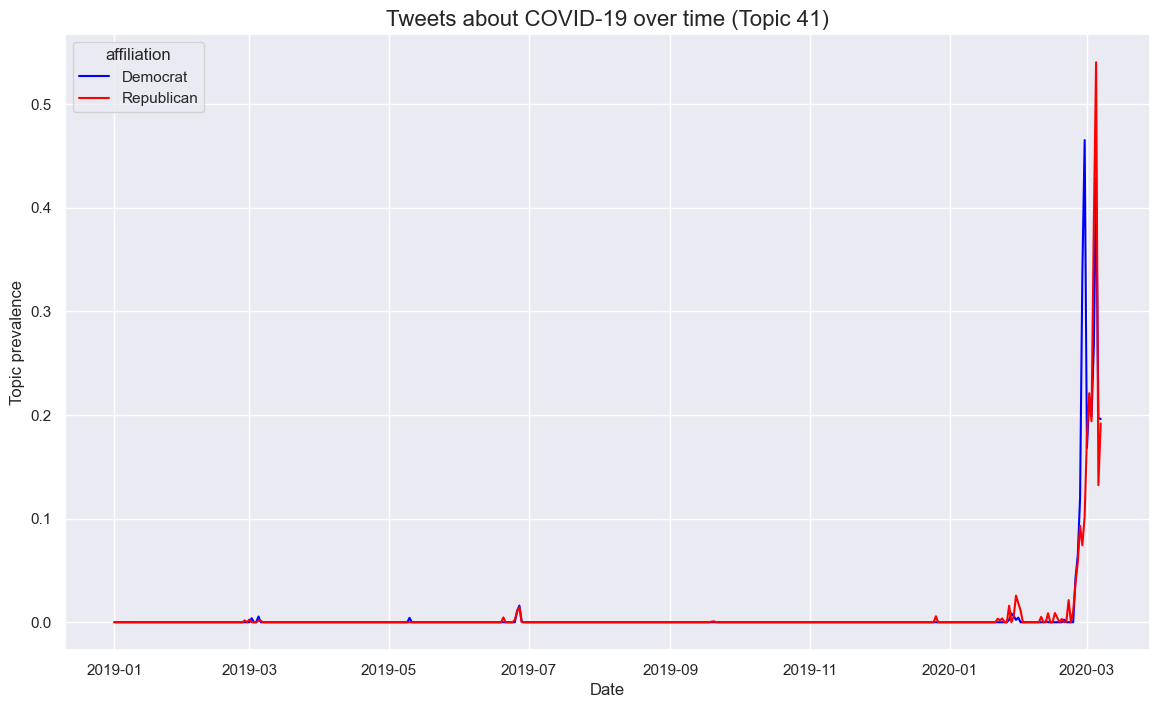

In [37]:
# 3. Making graph of development of the coronavirus topic 

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing color palette
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset - choosing x, y and grouping variable (hue) to group by affiliation
sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df, palette = palette)

#Setting title and labels
plt.title('Tweets about COVID-19 over time (Topic 41)', fontsize = 16) 
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

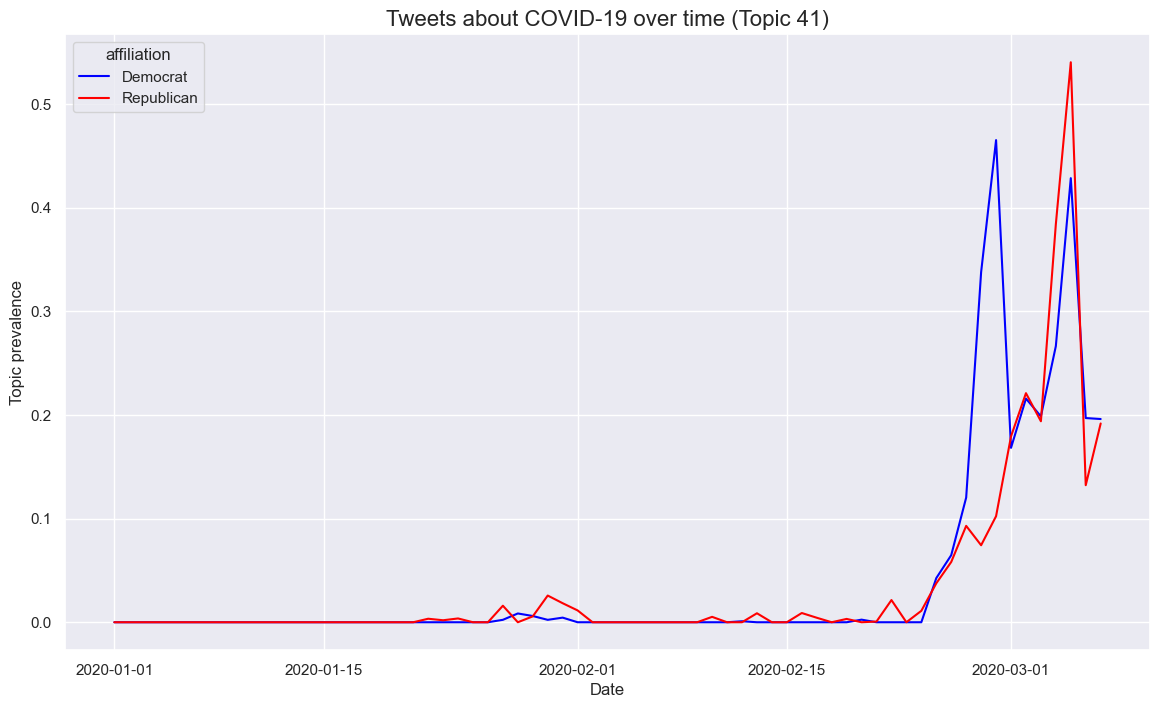

In [38]:
# 4.  Making graph of development of the coronavirus topic in 2020

plt.figure(figsize = (14,8))
palette = ['blue','red']

sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', 
             data = gamma_df.loc[gamma_df.date > datetime(2019,12,31)], #restricting data to only include 2020
             palette = palette)

plt.title('Tweets about COVID-19 over time (Topic 41)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# plt.savefig('corona_topic_over_time2020_100topics_2.jpg') # Saving graph
plt.show()